## Import Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats

## Dataset

In [2]:
df = pd.read_csv('vgchartz-2024.csv')
df.head()

,img,title,console,genre,publisher,developer,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,release_date,last_update
0,/games/boxart/full_6510540AmericaFrontccc.jpg,Grand Theft Auto V,PS3,Action,Rockstar Games,Rockstar North,9.4,20.32,6.37,0.99,9.85,3.12,2013-09-17,NaN
1,/games/boxart/full_5563178AmericaFrontccc.jpg,Grand Theft Auto V,PS4,Action,Rockstar Games,Rockstar North,9.7,19.39,6.06,0.60,9.71,3.02,2014-11-18,2018-01-03
2,/games/boxart/827563ccc.jpg,Grand Theft Auto: Vice City,PS2,Action,Rockstar Games,Rockstar North,9.6,16.15,8.41,0.47,5.49,1.78,2002-10-28,NaN
3,/games/boxart/full_9218923AmericaFrontccc.jpg,Grand Theft Auto V,X360,Action,Rockstar Games,Rockstar North,NaN,15.86,9.06,0.06,5.33,1.42,2013-09-17,NaN
4,/games/boxart/full_4990510AmericaFrontccc.jpg,Call of Duty: Black Ops 3,PS4,Shooter,Activision,Treyarch,8.1,15.09,6.18,0.41,6.05,2.44,2015-11-06,2018-01-14


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64016 entries, 0 to 64015
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   img           64016 non-null  object 
 1   title         64016 non-null  object 
 2   console       64016 non-null  object 
 3   genre         64016 non-null  object 
 4   publisher     64016 non-null  object 
 5   developer     63999 non-null  object 
 6   critic_score  6678 non-null   float64
 7   total_sales   18922 non-null  float64
 8   na_sales      12637 non-null  float64
 9   jp_sales      6726 non-null   float64
 10  pal_sales     12824 non-null  float64
 11  other_sales   15128 non-null  float64
 12  release_date  56965 non-null  object 
 13  last_update   17879 non-null  object 
dtypes: float64(6), object(8)
memory usage: 6.8+ MB


## Data Cleaning

In [4]:
df.isnull().sum()

img                 0
title               0
console             0
genre               0
publisher           0
developer          17
critic_score    57338
total_sales     45094
na_sales        51379
jp_sales        57290
pal_sales       51192
other_sales     48888
release_date     7051
last_update     46137
dtype: int64

### Drop Unneccessary Columns

In [5]:
df1 = df.drop(['img', 'developer','last_update'], axis = 1)

### Data Imputation - Critic Score

In [6]:
# Fill missing critic_score values with mode within each game title
df1['critic_score'] = df1.groupby('title')['critic_score'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.isnull().all() else x)

# Fill remaining missing critic_score values with mode based on console
df1['critic_score'] = df1.groupby('console')['critic_score'].transform(lambda x: x.fillna(x.mode().iloc[0]) if not x.isnull().all() else x)


### Remove Rows with Excessively Missing Data

In [7]:
sales = ['total_sales', 'jp_sales', 'na_sales', 'pal_sales', 'other_sales']
# Remove rows with less than the 25% non-null sales values
df2 = df1.dropna(thresh=len(sales) * 0.25, subset=sales)

In [8]:
df2 = df2.dropna(subset=['critic_score'])

### Data Imputation - Impute Missing Regional Sales with Single Null Check

In [9]:
regional_sales = ['jp_sales', 'na_sales', 'pal_sales', 'other_sales']

# Condition to find rows where only one regional sales is missing, but total sales is not null
condition = df2['total_sales'].notnull() & (df2[regional_sales].isnull().sum(axis=1) == 1)

# Fill the missing regional sales for these rows
df2.loc[condition, regional_sales] = df2.loc[condition, regional_sales].fillna(
    df2.loc[condition, 'total_sales'] - df2.loc[condition, regional_sales].sum(axis=1, skipna=True), axis=0)

### Data Imputation - Impute Missing Regional Sales

In [10]:
# Define tolerance
tolerance = 0.1

# Calculate sum of non-null regional sales
sum_regional_sales = df2[regional_sales].sum(axis=1, skipna=True)

# Calculate the lower and upper bounds for total_sales
lower_bound = df2['total_sales'] - tolerance
upper_bound = df2['total_sales'] + tolerance

# Check condition where sum of non-null regional sales is within tolerance of total_sales
condition = (sum_regional_sales >= lower_bound) & (sum_regional_sales <= upper_bound) & (df2['total_sales'].notnull())

# Fill null values in regional sales columns where condition is True
df2.loc[condition, regional_sales] = df2.loc[condition, regional_sales].fillna(0)


In [11]:
df2.isnull().sum()

title            0
console          0
genre            0
publisher        0
critic_score     0
total_sales      0
na_sales         0
jp_sales         0
pal_sales        0
other_sales      0
release_date    90
dtype: int64

### Drop Remaining Null Values

In [12]:
df2= df2.dropna()

### Transform Data Type

In [13]:
df2['release_date'] = pd.to_datetime(df2['release_date'])
df2['console'] = df2['console'].astype('category')
df2['genre'] = df2['genre'].astype('category')
df2['publisher'] = df2['publisher'].astype('category')
df2['critic_score'] = df2['critic_score'].astype(int)

### Extract Date Components

In [14]:
df2['year'] = df2['release_date'].dt.year
df2['month'] = df2['release_date'].dt.month
df2['day'] = df2['release_date'].dt.day

### Validate Data Consistency: Sales

In [15]:
# Define tolerance
tolerance = 0.1

# Calculate sum of regional sales
sum_regional_sales = df2[regional_sales].sum(axis=1)

# Check consistency
inconsistent_rows = df2[abs(df2['total_sales'] - sum_regional_sales) > tolerance]

# Display rows where consistency check is False
print("Rows with inconsistent regional sales:")
print(inconsistent_rows)

Rows with inconsistent regional sales:
Empty DataFrame
Columns: [title, console, genre, publisher, critic_score, total_sales, na_sales, jp_sales, pal_sales, other_sales, release_date, year, month, day]
Index: []


### Validate Data Consistency: Critic Score 

In [16]:
# Assuming 'critic_score' has outliers greater than 10 and less than 0
outliers = df2[(df2['critic_score'] > 10) | (df2['critic_score'] < 0)]
print("Any Outliers in 'critic_score':", outliers.shape[0] )

Any Outliers in 'critic_score': 0


## Dataset Summary after Data Cleaning

In [17]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18831 entries, 0 to 18921
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   title         18831 non-null  object        
 1   console       18831 non-null  category      
 2   genre         18831 non-null  category      
 3   publisher     18831 non-null  category      
 4   critic_score  18831 non-null  int64         
 5   total_sales   18831 non-null  float64       
 6   na_sales      18831 non-null  float64       
 7   jp_sales      18831 non-null  float64       
 8   pal_sales     18831 non-null  float64       
 9   other_sales   18831 non-null  float64       
 10  release_date  18831 non-null  datetime64[ns]
 11  year          18831 non-null  int64         
 12  month         18831 non-null  int64         
 13  day           18831 non-null  int64         
dtypes: category(3), datetime64[ns](1), float64(5), int64(4), object(1)
memory usage: 1.8+ 

After completing the data cleaning process, the dataset was streamlined from 64,016 records to 18,831 records.

### Initial Statistics for Categorical Data

In [18]:
games = df2['title'].unique()
consoles = df2['console'].unique()
years = df2['year'].unique() # Assume year is catgorical here
genres = df2['genre'].unique()
publishers = df2['publisher'].unique()

print("Number of Unique Values in Categorical Columns")
print("Games: ",len(games))
print("Consoles: ",len(consoles))
print("Years: ",len(years))
print("Genres: ",len(genres))
print("Publishers: ",len(publishers))

Number of Unique Values in Categorical Columns
Games:  12934
Consoles:  38
Years:  44
Genres:  20
Publishers:  739


### Statistic Summary

In [19]:
df2.describe()

,critic_score,total_sales,na_sales,jp_sales,pal_sales,other_sales,year,month,day
count,18831.000000,18831.000000,18831.000000,18831.000000,18831.000000,18831.000000,18831.000000,18831.000000,18831.000000
mean,7.065690,0.350448,0.177620,0.036374,0.101675,0.034545,2007.687537,7.298603,16.843821
std,1.093498,0.809057,0.423984,0.112082,0.331360,0.114774,6.028087,3.400852,9.118444
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1977.000000,1.000000,1.000000
25%,7.000000,0.030000,0.000000,0.000000,0.000000,0.000000,2004.000000,4.000000,9.000000
50%,7.000000,0.120000,0.050000,0.000000,0.010000,0.010000,2008.000000,8.000000,18.000000
75%,8.000000,0.350000,0.170000,0.020000,0.070000,0.020000,2011.000000,10.000000,25.000000
max,10.000000,20.320000,9.760000,2.130000,9.850000,3.120000,2020.000000,12.000000,31.000000


## Univariate Analysis

### Sales

In [20]:
print("Sales of each regions:")
print(df2[['total_sales','na_sales', 'jp_sales','pal_sales', 'other_sales']].sum())

Sales of each regions:
total_sales    6599.29
na_sales       3344.76
jp_sales        684.96
pal_sales      1914.64
other_sales     650.51
dtype: float64


##### Insights: **Sales Trends**:
- The North American region dominates the video gaming industry, boasting sales of 3.34 billion copies.

### Metacritic score (out of 10)

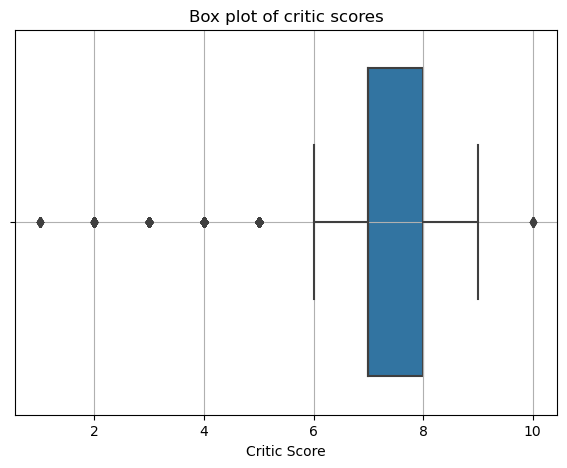

In [21]:
plt.figure(figsize=(7, 5))
sns.boxplot(x=df2['critic_score'].dropna())
plt.title('Box plot of critic scores')
plt.xlabel('Critic Score')
plt.grid(True)
plt.show()

In [22]:
print("Summary Statistics of Critic Scores:")
print(df2['critic_score'].describe())

Summary Statistics of Critic Scores:
count    18831.000000
mean         7.065690
std          1.093498
min          1.000000
25%          7.000000
50%          7.000000
75%          8.000000
max         10.000000
Name: critic_score, dtype: float64


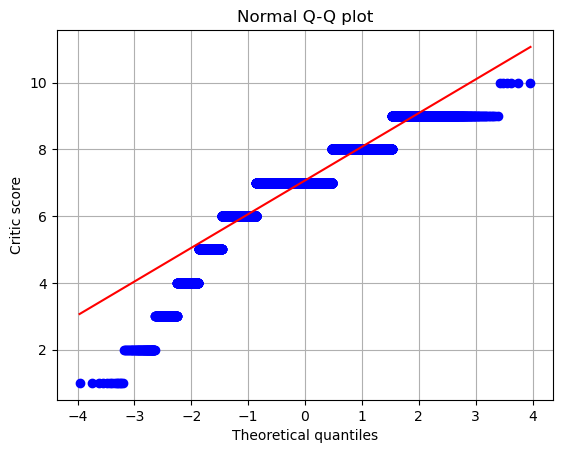

In [23]:
# Create Q-Q plot, check for normality
stats.probplot(df2['critic_score'], dist="norm", plot=plt)
plt.title('Normal Q-Q plot')
plt.xlabel('Theoretical quantiles')
plt.ylabel('Critic score')
plt.grid(True)
plt.show()


The quantile-normal plot reveals a right-skewed distribution, consistent with the observations from the box plot analysis.

##### Insights: **Critic Scores**:

- The box plot shows that the majority of critic scores are concentrated between 7 and 8. This indicates that most games receive high critic scores, suggesting a generally positive reception from critics.

- The interquartile range (IQR) spans from 7 to 8, showing that most games received scores within this moderate to high range.

- There are outliers below the lower whisker, suggesting a negatively skewed distribution of critic scores. These outliers indicate that some games were poorly received.

### Console

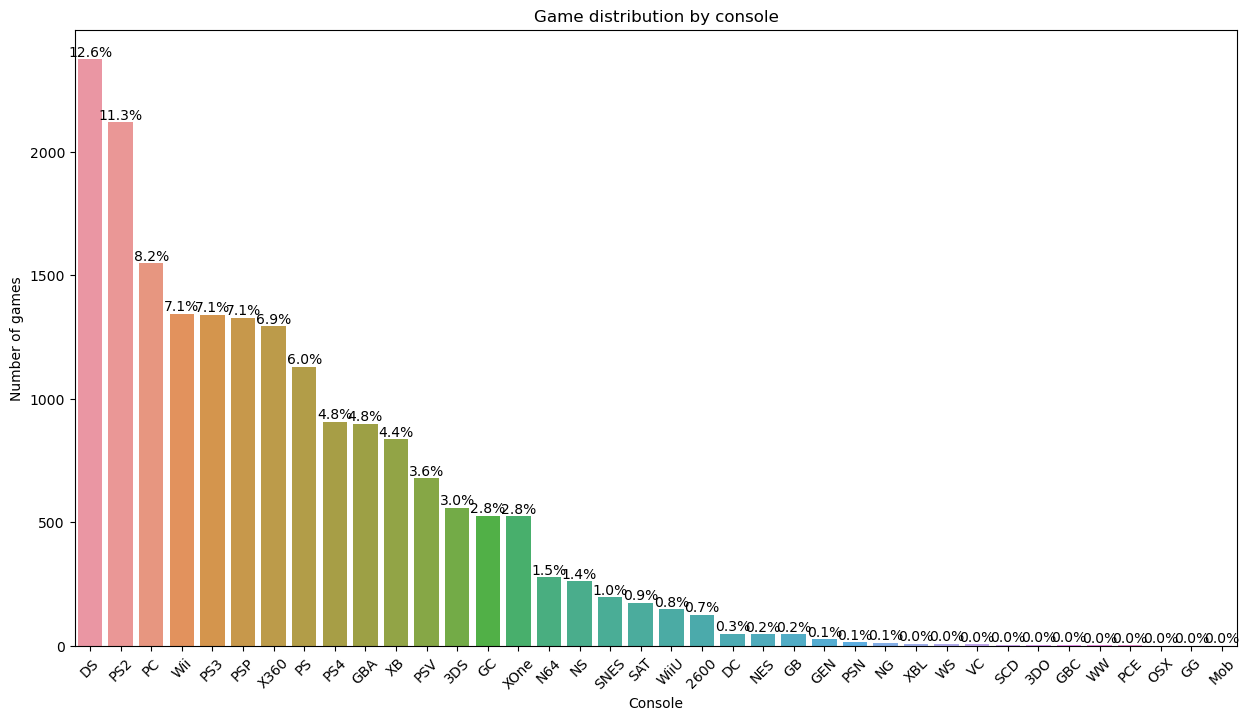

In [24]:
plt.figure(figsize=(15, 8))
sns.countplot(x=df2['console'], order=df2['console'].value_counts().index)
plt.title('Game distribution by console')
plt.xlabel('Console')
plt.ylabel('Number of games')
plt.xticks(rotation=45)

# Add percentage labels on each bar
total = len(df2)
for p in plt.gca().patches:
    percentage = '{:.1f}%'.format((p.get_height() / total) * 100)
    x = p.get_x() + p.get_width() / 2
    y = p.get_height() + 0.5
    plt.text(x, y, percentage, ha='center', va='bottom')

plt.show()

##### Insights: **Console**
- The Nintendo DS and Sony PS2 were the most popular game consoles, each commanding 12.6% and 11.3% of market share, highlighting intense competition between the two platforms.

- Sony's PlayStation series (including PSP, PS, PS2, PS3, PS4) dominates the video game industry, collectively holding a commanding share of approximately 36.3%.

### Genre

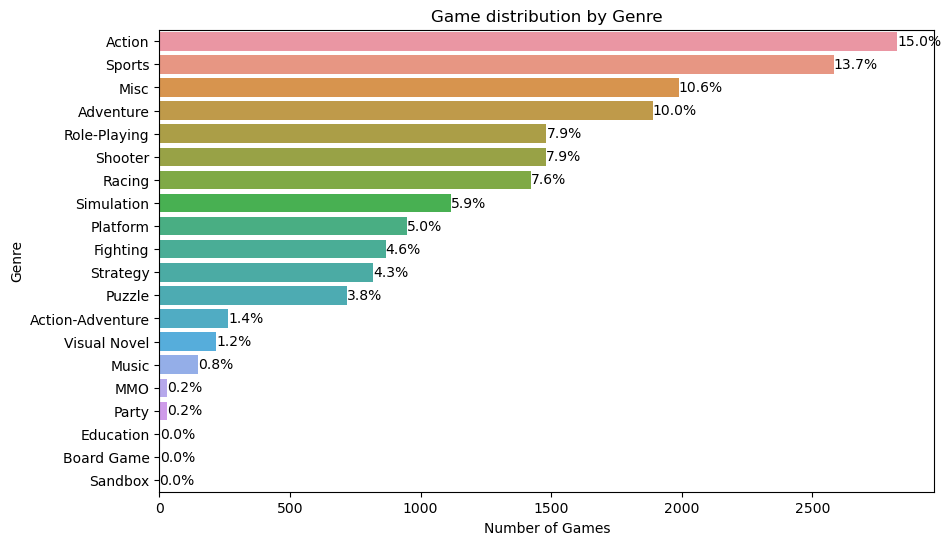

In [25]:
plt.figure(figsize=(10, 6))
sns.countplot(y=df2['genre'], order=df2['genre'].value_counts().index)
plt.title('Game distribution by Genre')
plt.xlabel('Number of Games')
plt.ylabel('Genre')

total = len(df2)
for p in plt.gca().patches:
    percentage = '{:.1f}%'.format((p.get_width() / total) * 100)
    x = p.get_x() + p.get_width() + 0.02
    y = p.get_y() + p.get_height() / 2
    plt.text(x, y, percentage, ha='left', va='center')

plt.show()


##### Insights: **Genre**
- Action games represent a significant portion of 15% of the gaming industry. Their popularity underscores a strong demand among gamers for immersive experiences, featuring dynamic elements such as combat and intense gameplay.

- Sport games account for 13.7% of the gaming market. These titles appeal stroorngly to fans of sports, with frequent updates reflecting real-world events like player transfers and seasonal championships, ensuring sustained popularity throughout the year. (e.g. FIFA, NBA)

- Genres like Education and board game have fewer releases, indicating limited market appeal or specialized interest.

### Publisher

In [26]:
# Get the value counts for publishers
publisher_counts = df2['publisher'].value_counts()

# Get the percentage of each publisher
publisher_percentages = df2['publisher'].value_counts(normalize=True) * 100

# Combine both counts and percentages into a single DataFrame
publisher_stats = pd.DataFrame({'Count': publisher_counts, 'Percentage': publisher_percentages})

publisher_stats.head(15)

,Count,Percentage
Activision,1044,5.544050
Ubisoft,1012,5.374117
Electronic Arts,843,4.476661
Konami,769,4.083692
THQ,726,3.855345
Sega,641,3.403962
Sony Computer Entertainment,568,3.016303
EA Sports,540,2.867612
Capcom,437,2.320641
Nintendo,384,2.039191


##### Insights: **Publisher**
- Activision (known for Call of duty and Overwatch) and Ubisoft (recognized for Assassin's Creed and Rainbox Six) emerge as leading publishers in the video gaming industry.

- Despite the presence of 739 publishers, the top 15 publishers collectively launch 44.8% of all games. This concentration underscores their profound influence on the gaming industry's release volume and market dynamics. Their dominance within this select group highlights their pivotal role in shaping trends and consumer preferences in the gaming market.

### Year

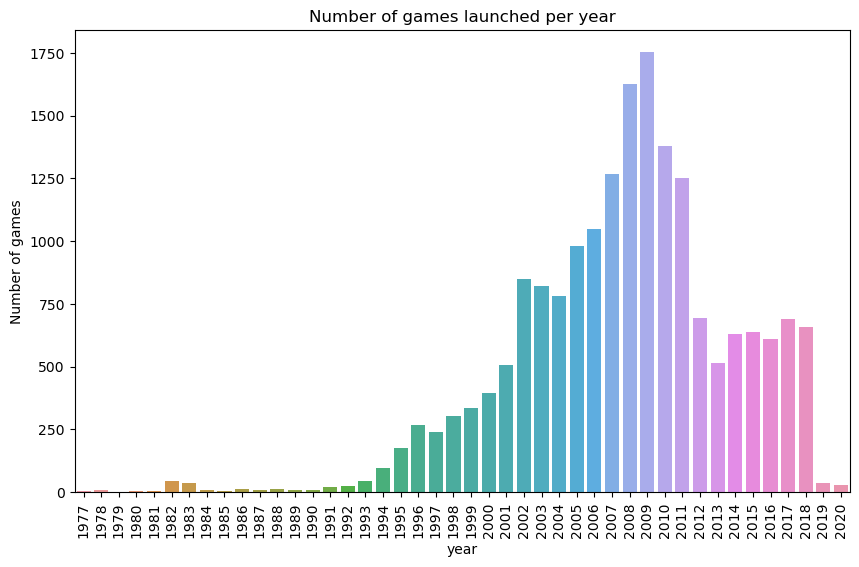

In [27]:
plt.figure(figsize=(10, 6))
sns.countplot(x=df2['year'])
plt.title('Number of games launched per year')
plt.ylabel('Number of games')
plt.xticks(rotation=90)
plt.show()

##### Insights: **Year**
- The significant surge in game launches from 2004 to 2009 corresponds with robust economic growth and advancements in technology, including the rise of mobile gaming and virtual reality (VR).

- The onset of the Great Recession in 2008 likely prompted a shift in consumer spending patterns and disposable income. The subsequent decline in game launches from 2009 to 2013 reflects the broader economic downturn and heightened cautiousness in consumer spending behaviors.


## Bivariate Analysis

### Tableau Interactive Dashboard

https://public.tableau.com/views/VideoG/Dashboard1?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link

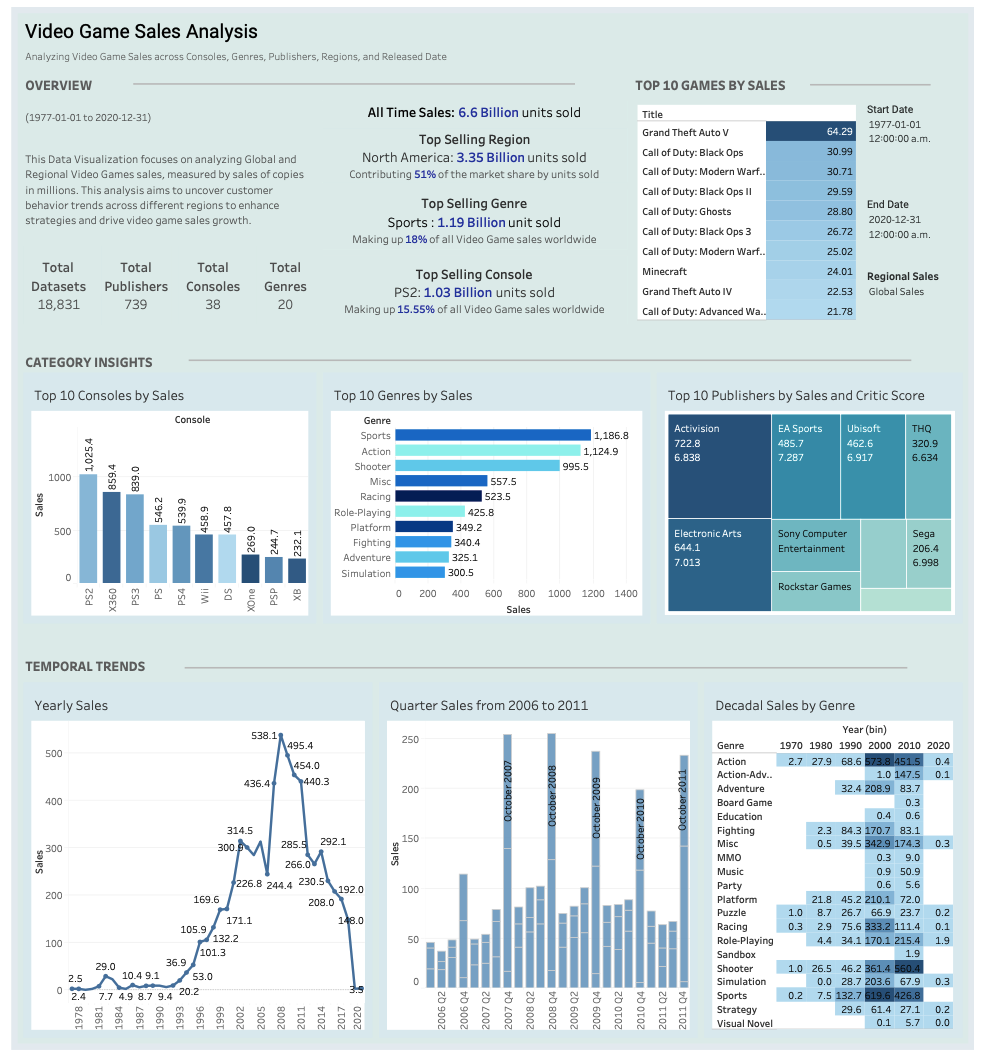

In [28]:
from IPython.display import Image
Image(filename='VGS Dashboard.png')

### Actionable Insights:

<span style="font-size: 17px;"> **Top Performing Games by Sales**
- Insights: 
  - ***Global Leader***: "Grand Theft Auto V" with 64.29 million units sold.
  - ***Japan's Favorite***: "Hot Shots Golf" with 4.26 million copies.
  - ***Regional Hits***: "Grand Theft Auto V" in North America (26.19 million) and Europe & Africa (28.14 million).
  - ***Franchise Dominance***: The "Grand Theft Auto" and "Call of Duty" series lead global video game sales.

- Actions: 
  - ***Expand Existing Series***: Develop new installments within the existing series. Introduce fresh storylines, characters, and gameplay mechanics to keep fans engaged.
  - ***Spin-Offs and Side Stories***: Create spin-offs or side stories set in the same universe. These can explore different aspects of the game world or focus on specific characters.
  - ***Collaborate with Other Franchises***: Consider crossover events with other successful franchises. This can attract fans from both series.


<span style="font-size: 17px;"> **Category Insights: Impact of Publishers on Video Game Sales and Ratings**
- Insights:
  - ***Market Leaders***: Activision (722.8 million units) and Electronic Arts (644.1 million units).
  - ***Consistent Quality***: Top 10 publishers have critic scores ranging of 7 to 8.

- Actions:
  - ***Collaborate with Leading Publishers***: Explore partnerships, collaborations, or learn from industry leaders to strengthen market position with successful strategies.
  - ***Maintain Quality Consistency***:  Prioritize high-quality game development to ensure consistent critic scores and market performance.

<span style="font-size: 17px;"> **Category Insights: Genre sales across different regions**
- Insights:
  - ***Gloabl Dominance***: Sports games with 1.19 billion copies sold.
  - ***Top Region***: North America leads in sales.
  - ***Regional Preferences***:
     - North America (607.4 million units) and other regions favor sports games.
     - Japan prefers role-playing games (130.03 million units).
     - Europe & Africa lead with aciton games (342.5 million units).

- Actions:
  - ***Targeted Regional Marketing***: Tailor marketing strategies and game development to align with regional preferences.
  - ***Expand Genre Variety***: Continue investing in and diversifying game genres, with an emphasis on sports and action games to meet global demand.


<span style="font-size: 17px;"> **Category Insights: Console sales across different regions**

- Insights: 
  - ***Global Dominance***: PS2 with 1.03 billion copies sold.
  - ***Top Region***: North America leads in sales.
  - ***Regional Preferences***:
      - North America: Prefers X360 (528.4 million units).
      - Japan: Prefers PS (88.28 million units).
      - Europe & Africa: Prefers PS3 (301.8 million units).

- Actions: 
  - ***Leverage Console Preferences***: Develop exclusive content and optimize games for the most popular consoles in each region to increase market penetration.
  - ***Revitalize Classic Consoles***: Consider releasing classic or remastered versions of popular games for the PS2 to tap into its large user base.


<span style="font-size: 17px;"> **Temporal Trends**

- Insights:
  - ***Sales Trends***: Surge from 2006 to 2008, decline from 2008 to 2013, despite a peak in game launches in 2009.
  - ***Seasonal Sales***: Highest sales in Q4 each year.
  - ***Genre Shifts Over the Decade***:
      - Action games grew from 68.6 million (1990s) to 573.8 million (2000s).
      - Sports games grew from 132.7 million (1990s) to 619.6 million (2000s).
  - ***Popularity Shifts Over the Decade***: Action games remain popular; sports games gained in the 2000s; shooter games dominated in the 2010s.

- Actions: 
  - ***Strategic Release Timing***: Schedule major game releases and marketing campaigns for the fourth quarter to maximize sales during the holiday season.
  - ***Analyze Decline Factors***: Conduct a thorough analysis of the factors that contributed to the decline in video game sales and adjust strategies to mitigate similar risks in the future.
  - ***Optimize for Popular Genres Over Time***: Keep track of genre trends and invest in the development of genres that show growing popularity to stay ahead of market demands.